In [3]:
import os

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler

import torchvision
from torchvision import models, transforms, datasets

import matplotlib.pyplot as plt
import time
import copy
from tqdm import tqdm

print("Your working directory is: ", os.getcwd())
torch.manual_seed(0)

/home/student/miniconda3/envs/hw_094295_env/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Your working directory is:  /home/student/HW2


In [1]:
import pickle
import numpy as np
from skimage import io
from skimage import transform as tf
from IPython.display import Image, display
from PIL import Image, ImageEnhance

In [4]:
# Use a prebuilt pytorch's ResNet50 model
model_ft = models.resnet50(pretrained=False)
# Fit the last layer for our specific task
num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs, 10)

In [5]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
ckpt = torch.load('trained_model_resnet_pick.pt')
model_ft.load_state_dict(ckpt)
model_ft.eval()
model_ft = model_ft.to(device)

In [6]:
# Training hyperparameters
BATCH_SIZE = 16
NUM_EPOCHS = 100
LR = 0.001

# Paths to your train and val directories
#train_dir = os.path.join("data", "train") ########
train_dir = 'data_extended/train'

# Resize the samples and transform them into tensors
data_transforms = transforms.Compose([transforms.Resize([64, 64]), transforms.ToTensor()])

# Create a pytorch dataset from a directory of images
train_dataset = datasets.ImageFolder(train_dir, data_transforms)

class_names = train_dataset.classes
idx_to_class = {i: c for i, c in enumerate(class_names)}
print("The classes are: ", idx_to_class)

# Dataloaders initialization
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)

The classes are:  {0: 'i', 1: 'ii', 2: 'iii', 3: 'iv', 4: 'ix', 5: 'v', 6: 'vi', 7: 'vii', 8: 'viii', 9: 'x'}


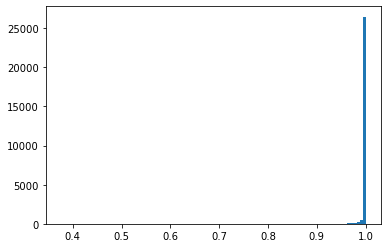

In [17]:
misslabeled = {label: [] for label in idx_to_class.values()}
best_prob = 0
best_prob_list = []
counter = 0
for tensor_label, file_label in zip(train_dataset, train_dataset.imgs):
    counter += 1
    tensor = tensor_label[0].unsqueeze(0).to(device)
    label = tensor_label[1]
    file = file_label[0]
    output = model_ft(tensor)
    output = torch.sigmoid(output)
    prob, pred = torch.max(output, 1)
    best_prob_list.append(prob.item())
    best_prob += prob.item()
    if pred.item() != label:
        misslabeled[idx_to_class[label]].append((file, idx_to_class[pred.item()]))



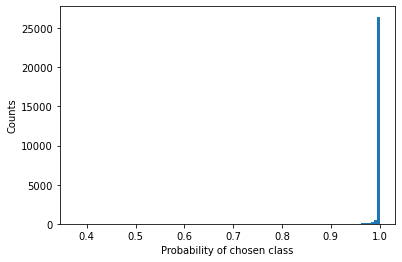

In [19]:
plt.hist(best_prob_list, bins=100)
plt.xlabel('Probability of chosen class')
plt.ylabel('Counts')
plt.show()

In [12]:
sum([len(v) for v in misslabeled.values()])

14

In [117]:
misslabeled['i']

[('HWRN_mod/i/1683395415_mod.png', 'ii'),
 ('HWRN_mod/i/180645601_mod.png', 'vi'),
 ('HWRN_mod/i/2379801092_mod.png', 'ii'),
 ('HWRN_mod/i/3039174331_mod.png', 'ii'),
 ('HWRN_mod/i/3446132194_mod.png', 'iii'),
 ('HWRN_mod/i/3897771876_mod.png', 'ii'),
 ('HWRN_mod/i/405503729_mod.png', 'ii'),
 ('HWRN_mod/i/6094716305_mod.png', 'ii'),
 ('HWRN_mod/i/6101560183_mod.png', 'iii'),
 ('HWRN_mod/i/6767672758_mod.png', 'ii'),
 ('HWRN_mod/i/8562062098_mod.png', 'ii'),
 ('HWRN_mod/i/9033801386_mod.png', 'iii'),
 ('HWRN_mod/i/9750768394_mod.png', 'ii')]

HWRN_mod/i/1683395415_mod.png
ii


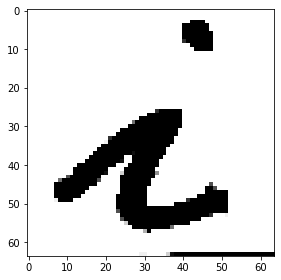

HWRN_mod/i/180645601_mod.png
vi


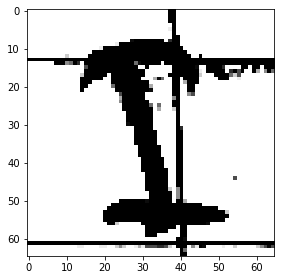

HWRN_mod/i/2379801092_mod.png
ii


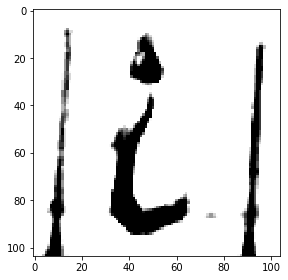

HWRN_mod/i/3039174331_mod.png
ii


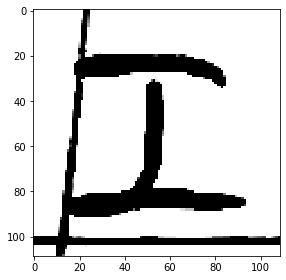

HWRN_mod/i/3446132194_mod.png
iii


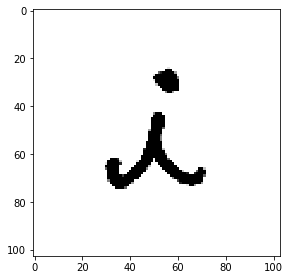

HWRN_mod/i/3897771876_mod.png
ii


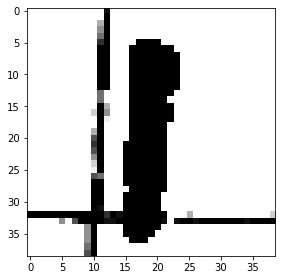

HWRN_mod/i/405503729_mod.png
ii


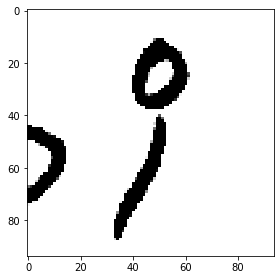

HWRN_mod/i/6094716305_mod.png
ii


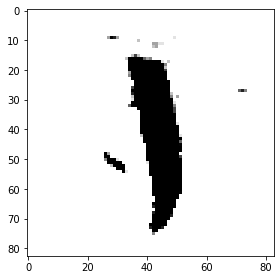

HWRN_mod/i/6101560183_mod.png
iii


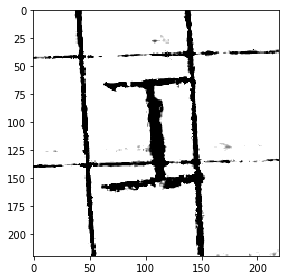

HWRN_mod/i/6767672758_mod.png
ii


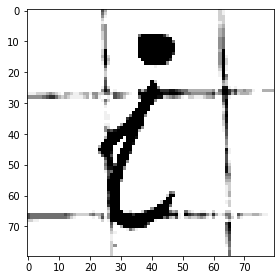

HWRN_mod/i/8562062098_mod.png
ii


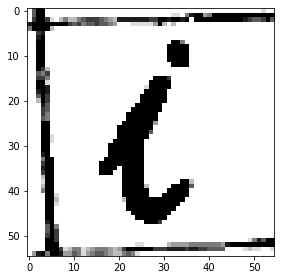

HWRN_mod/i/9033801386_mod.png
iii


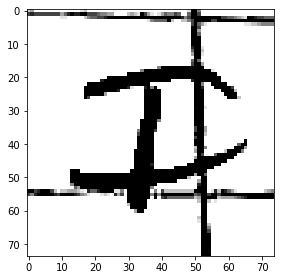

HWRN_mod/i/9750768394_mod.png
ii


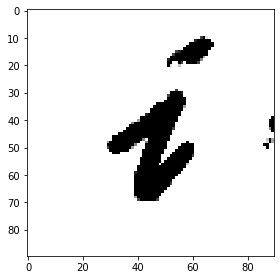

In [118]:
for file, pred in misslabeled['i']:
    img = io.imread(file)
    print(file)
    print(pred)
    io.imshow(img)
    io.show()

In [8]:
# Use the model object to select the desired layer
layer = model_ft._modules.get('avgpool')

def get_vector(image):
    # Create a vector of zeros that will hold our feature vector
    # The 'avgpool' layer has an output size of 512
    my_embedding = torch.zeros(2048)

    # Define a function that will copy the output of a layer
    def copy_data(m, i, o):
        my_embedding.copy_(o.flatten())                 # <-- flatten

    # Attach that function to our selected layer
    h = layer.register_forward_hook(copy_data)
    # Run the model on our transformed image
    with torch.no_grad():                               # <-- no_grad context
        model_ft(image)                                 # <-- unsqueeze
    # Detach our copy function from the layer
    h.remove()
    # Return the feature vector
    return my_embedding

files_list = []
label_list = []
vecs_list = []

c = 0

for tensor_label, file_label in zip(train_dataset, train_dataset.imgs):
    tensor = tensor_label[0].unsqueeze(0).to(device)
    label = tensor_label[1]
    file = file_label[0]
    v = np.array(get_vector(tensor))
    
    files_list.append(file)
    label_list.append(idx_to_class[label])
    vecs_list.append(v)
    if not c % 5000:
        print(f"Done {100*c/27643}")
    c += 1

Done 0.0
Done 18.08776182035235
Done 36.1755236407047
Done 54.26328546105705
Done 72.3510472814094
Done 90.43880910176175


In [9]:
vecs_list = np.array(vecs_list)
vecs_list.shape

(27643, 2048)

In [10]:
np.save('train_imgs_vecs.npy', vecs_list)

with open('train_imgs_files_list.pkl', 'wb') as f:
    pickle.dump(files_list, f)

with open('train_imgs_labels_list.pkl', 'wb') as f:
    pickle.dump(label_list, f)